# Regularization

Deep Learning models have so much flexibility and capacity that **overfitting can be a serious problem**, if the training dataset is not big enough. Sure it does well on the training set, but the learned network **doesn't generalize to new examples** that it has never seen!

Let's get started!

## Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Loading the dataset
Each dot corresponds to a position on the football field where a football player has hit the ball with his/her head after the French goal keeper has shot the ball from the left side of the football field.
- If the dot is blue, it means the French player managed to hit the ball with his/her head
- If the dot is red, it means the other team's player hit the ball with their head

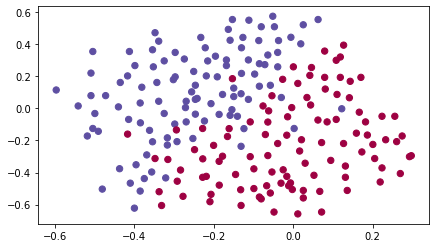

In [2]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

## Non-Regularized Model

Wewill use the following neural network. This model can be used:
- in *regularization mode* -- by setting the `lambd` input to a non-zero value. We use "`lambd`" instead of "`lambda`" because "`lambda`" is a reserved keyword in Python. 
- in *dropout mode* -- by setting the `keep_prob` to a value less than one

Wewill first try the model without any regularization. Then, wewill implement:
- *L2 regularization* -- functions: "`compute_cost_with_regularization()`" and "`backward_propagation_with_regularization()`"
- *Dropout* -- functions: "`forward_propagation_with_dropout()`" and "`backward_propagation_with_dropout()`"

In [3]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):
    """
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (output size, number of examples)
    learning_rate -- learning rate of the optimization
    num_iterations -- number of iterations of the optimization loop
    print_cost -- If True, print the cost every 10000 iterations
    lambd -- regularization hyperparameter, scalar
    keep_prob - probability of keeping a neuron active during drop-out, scalar.
    
    Returns:
    parameters -- parameters learned by the model. They can then be used to predict.
    """
        
    grads = {}
    costs = []                            # to keep track of the cost
    m = X.shape[1]                        # number of examples
    layers_dims = [X.shape[0], 20, 3, 1]
    
    # Initialize parameters dictionary.
    parameters = initialize_parameters(layers_dims)

    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # Cost function
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            
        # Backward propagation.
        assert (lambd == 0 or keep_prob == 1)   # it is possible to use both L2 regularization and dropout, 
                                                # but this assignment will only explore one at a time
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 10000 iterations
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Let's train the model without any regularization, and observe the accuracy on the train/test sets.

Cost after iteration 0: 0.6557412523481002
Cost after iteration 10000: 0.16329987525724216
Cost after iteration 20000: 0.1385164242327309


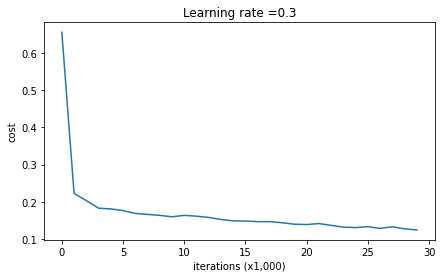

On the training set:
Accuracy: 0.9478672985781991
On the test set:
Accuracy: 0.915


In [4]:
parameters = model(train_X, train_Y)
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

The train accuracy is 91.5% while the test accuracy is 91.5%. This is the baseline model (you will observe the impact of regularization on this model).

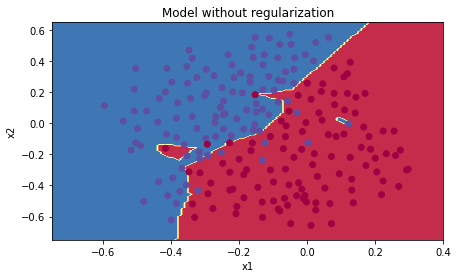

In [5]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

The non-regularized model is obviously overfitting the training set. It is fitting the noisy points! Lets now look at two techniques to reduce overfitting.

## L2 Regularization

The standard way to avoid overfitting is called **L2 regularization**. It consists of appropriately modifying your cost function, from:
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} \tag{1}$$
To:
$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$

Let's modify your cost and observe the consequences.

In [6]:
def compute_cost_with_regularization(A3, Y, parameters, lambd):
    """
    Implement the cost function with L2 regularization. See formula (2) above.
    
    Arguments:
    A3 -- post-activation, output of forward propagation, of shape (output size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    parameters -- python dictionary containing parameters of the model
    
    Returns:
    cost - value of the regularized loss function (formula (2))
    """
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = compute_cost(A3, Y) # This gives you the cross-entropy part of the cost
    
    L2_regularization_cost = (1./m) * (lambd/2.) * ( np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)) )
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

Of course, because we changed the cost, we have to change backward propagation as well! All the gradients have to be computed with respect to this new cost.

In [7]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
    """
    Implements the backward propagation of our baseline model to which we added an L2 regularization.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation()
    lambd -- regularization hyperparameter, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T) + lambd/m * W3
    db3 = 1. / m * np.sum(dZ3, axis=1, keepdims=True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T) + lambd/m * W2
    db2 = 1. / m * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T) + lambd/m * W1
    db1 = 1. / m * np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

Let's now run the model with L2 regularization $(\lambda = 0.7)$. The `model()` function will call: 
- `compute_cost_with_regularization` instead of `compute_cost`
- `backward_propagation_with_regularization` instead of `backward_propagation`

Cost after iteration 0: 0.6974484493131264
Cost after iteration 10000: 0.26849188732822393
Cost after iteration 20000: 0.2680916337127301


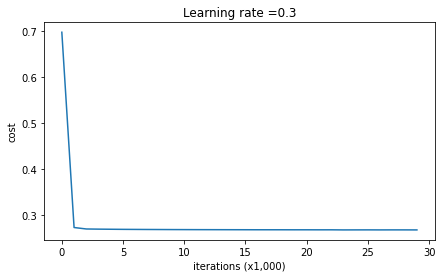

On the train set:
Accuracy: 0.9383886255924171
On the test set:
Accuracy: 0.93


In [8]:
parameters = model(train_X, train_Y, lambd = 0.7)
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

Congrats, the test set accuracy increased to 93%.

We are not overfitting the training data anymore. Let's plot the decision boundary.

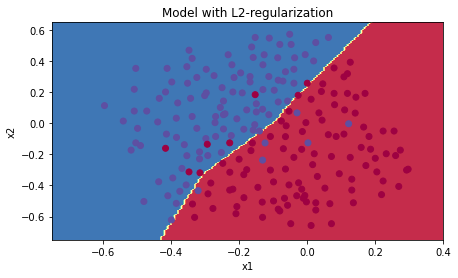

In [9]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## Dropout
Finally, dropout is a widely used regularization technique that is specific to deep learning. It randomly shuts down some neurons in each iteration. Watch these two videos to see what this means!

When you shut some neurons down, you actually modify your model. The idea behind drop-out is that at each iteration, you train a different model that uses only a subset of your neurons. With dropout, your neurons thus become less sensitive to the activation of one other specific neuron, because that other neuron might be shut down at any time.



In [10]:
def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):
    """
    Implements the forward propagation: LINEAR -> RELU + DROPOUT -> LINEAR -> RELU + DROPOUT -> LINEAR -> SIGMOID.
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix of shape (20, 2)
                    b1 -- bias vector of shape (20, 1)
                    W2 -- weight matrix of shape (3, 20)
                    b2 -- bias vector of shape (3, 1)
                    W3 -- weight matrix of shape (1, 3)
                    b3 -- bias vector of shape (1, 1)
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    A3 -- last activation value, output of the forward propagation, of shape (1,1)
    cache -- tuple, information stored for computing the backward propagation
    """
    
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    D1 = np.random.rand(A1.shape[0], A1.shape[1])
    D1 = D1 < keep_prob 
    A1 = A1 * D1
    A1 = A1 / keep_prob
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    D2 = np.random.rand(A2.shape[0], A2.shape[1])
    D2 = D2 < keep_prob
    A2 = A2 * D2
    A2 = A2 / keep_prob
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

In [11]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    """
    Implements the backward propagation of our baseline model to which we added dropout.
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation_with_dropout()
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims=True)
    dA2 = np.dot(W3.T, dZ3)
    dA2 =   dA2 * D2
    dA2 = dA2 / keep_prob
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims=True)
    dA1 = np.dot(W2.T, dZ2)
    dA1 = dA1 * D1
    dA1 = dA1 / keep_prob
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

Let's now run the model with dropout (`keep_prob = 0.86`). It means at every iteration you shut down each neurons of layer 1 and 2 with 14% probability. The function `model()` will now call:
- `forward_propagation_with_dropout` instead of `forward_propagation`.
- `backward_propagation_with_dropout` instead of `backward_propagation`.

Cost after iteration 0: 0.6579307804914392
Cost after iteration 10000: 0.20532740528629712
Cost after iteration 20000: 0.18147396893252055


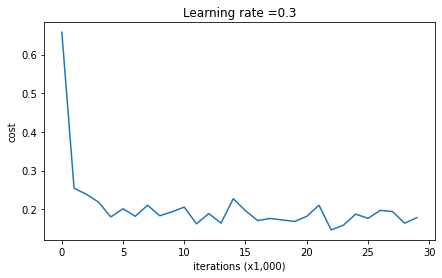

On the train set:
Accuracy: 0.9478672985781991
On the test set:
Accuracy: 0.935


In [13]:
parameters = model(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.3)

print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

Dropout works great! The test accuracy has increased again (to 95%)! Your model is not overfitting the training set and does a great job on the test set. The French football team will be forever grateful to you! 

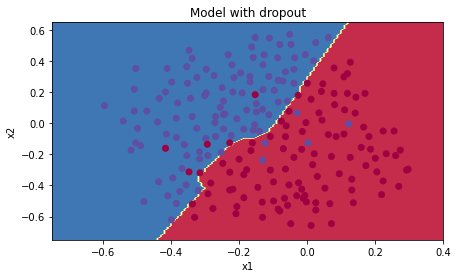

In [14]:
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## Conclusions

**Here are the results of our three models**: 

<table> 
    <tr>
        <td>
        <b>model</b>
        </td>
        <td>
        <b>train accuracy</b>
        </td>
        <td>
        <b>test accuracy</b>
        </td>
    </tr>
        <td>
        3-layer NN without regularization
        </td>
        <td>
        95%
        </td>
        <td>
        91.5%
        </td>
    <tr>
        <td>
        3-layer NN with L2-regularization
        </td>
        <td>
        94%
        </td>
        <td>
        93%
        </td>
    </tr>
    <tr>
        <td>
        3-layer NN with dropout
        </td>
        <td>
        93%
        </td>
        <td>
        95%
        </td>
    </tr>
</table> 